In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
# sys.path.insert(0, '../utils')

In [105]:
def imshow_pair(im, gdt, vmin1=0, vmax1=1, vmin2=0, vmax2=1):
    f, ax = plt.subplots(1, 2, figsize=(8,4))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [10]:
import torch
import torchvision.transforms as tr
from utils.get_loaders import get_train_val_loaders
from models.get_model import get_arch
from torch.nn import functional as F

In [4]:
csv_train = 'data/DRIVE/train_av.csv'
csv_val = csv_train.replace('train', 'val')

In [5]:
n_classes=4
label_values=[0, 85, 170, 255]

In [6]:
train_loader, val_loader = get_train_val_loaders(csv_path_train=csv_train, 
                                                 csv_path_val=csv_val, 
                                                 batch_size=2, tg_size=(512,512), 
                                                 label_values=label_values, num_workers=8)

In [7]:
print('* Instantiating a {} model'.format('wnet'))
model = get_arch('big_wnet', n_classes=n_classes)

* Instantiating a wnet model


In [8]:
from utils.model_saving_loading import load_model
model, stats = load_model(model, 'experiments/big_wnet_drive_av/', 'cpu')

In [9]:
(inputs, labels) = next(iter(val_loader))

In [15]:
labels.shape

torch.Size([2, 512, 512])

In [11]:
logits_aux, logits = model(inputs)
probs = torch.nn.Softmax(dim=1)(logits).detach()

In [17]:
labels_oh = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)

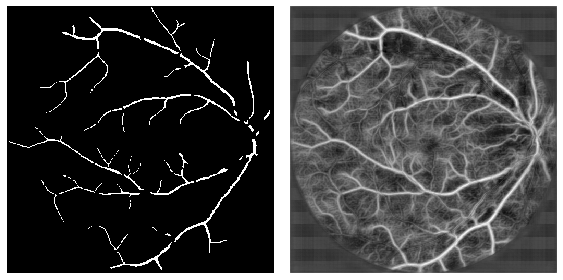

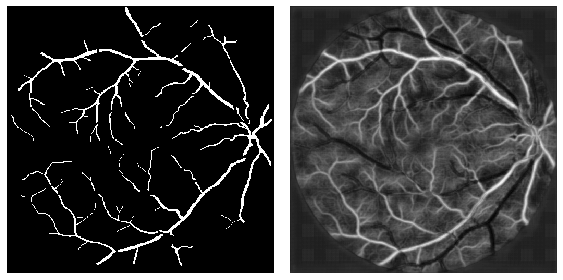

In [129]:
imshow_pair(labels_oh[bb,2],logits[bb,2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)
imshow_pair(labels_oh[bb,3],logits[bb,3].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)

In [164]:
bb=0
ll=2
idd = 250
idd2 = 150
off1 = 100
off2 = 100

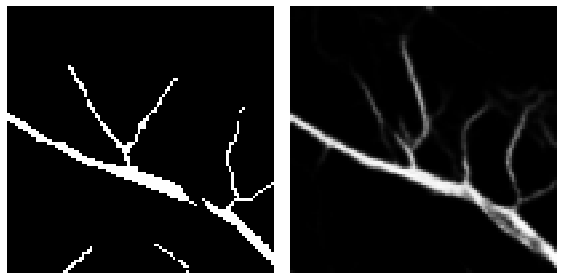

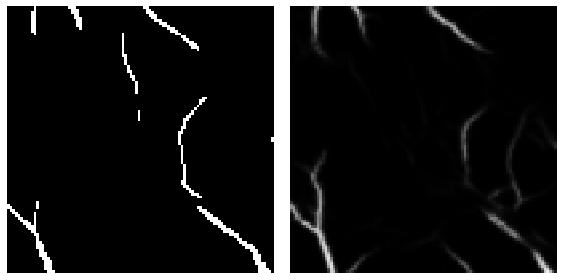

In [162]:
imshow_pair(labels_oh[bb,2,idd:idd+off1,idd2:idd2+off2],probs[bb,2,idd:idd+off1,idd2:idd2+off2].detach())
imshow_pair(labels_oh[bb,3,idd:idd+off1,idd2:idd2+off2],probs[bb,3,idd:idd+off1,idd2:idd2+off2].detach())

In [108]:
bb=0
ll=3
idd = 0
idd2 = 270
off1 = 100
off2 = 80

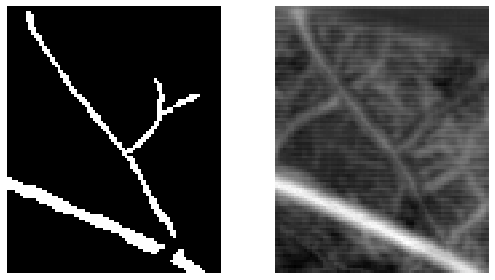

In [109]:
imshow_pair(labels_oh[bb,2,idd:idd+off1,idd2:idd2+off2],logits[bb,2,idd:idd+off1,idd2:idd2+off2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)

In [180]:
bb=0
ll=0
idd = 0
idd2 = 170
off1 = 200
off2 = 200

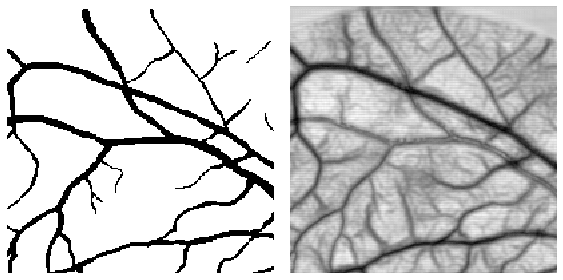

In [181]:
imshow_pair(labels_oh[bb,0,idd:idd+off1,idd2:idd2+off2],logits[bb,0,idd:idd+off1,idd2:idd2+off2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)

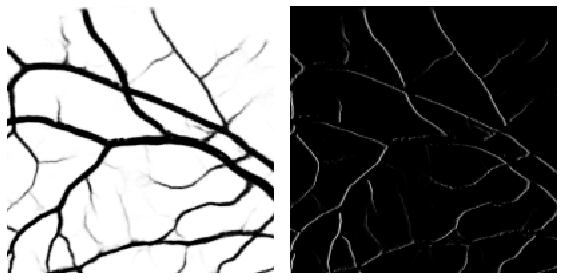

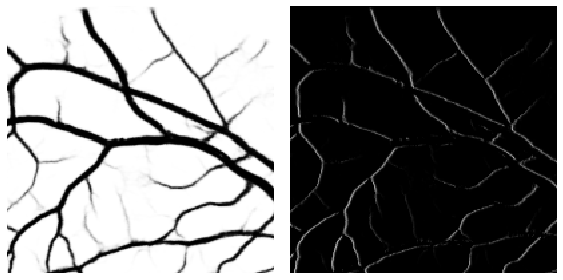

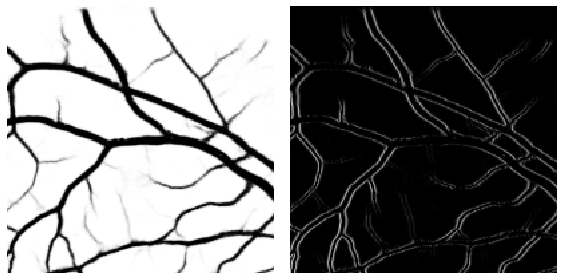

In [231]:
# xi,j - xi,j+1 (horizontal gradient, bright to dark: high pos values)
tv_r = torch.sub(probs, torch.roll(probs, shifts=-1, dims=-1)).detach()

# xi,j - xi,j-1 (horizontal gradient, dark to bright: high pos values)
tv_l = torch.sub(probs, torch.roll(probs, shifts=1, dims=-1)).detach() 

# combo: high pos value in bright to dark and dark to bright jumps only
tv_lr = torch.max(tv_r, tv_l)

imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv_r[bb,ll,idd:idd+off1,idd2:idd2+off2])
imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv_l[bb,ll,idd:idd+off1,idd2:idd2+off2])
imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], tv_lr[bb,ll,idd:idd+off1,idd2:idd2+off2])

In [233]:
masked_probs_high = torch.nn.Softmax(dim=1)(logits).detach()
masked_probs_high[~labels_oh]=3 # assign high values outside labels

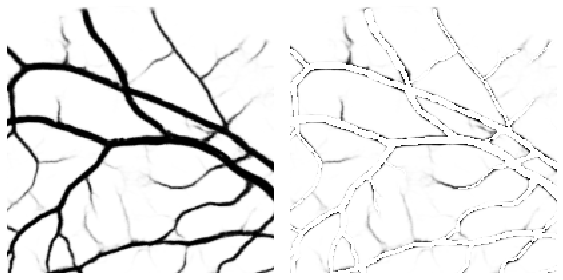

In [234]:
imshow_pair(probs[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_probs_high[bb,ll,idd:idd+off1,idd2:idd2+off2])

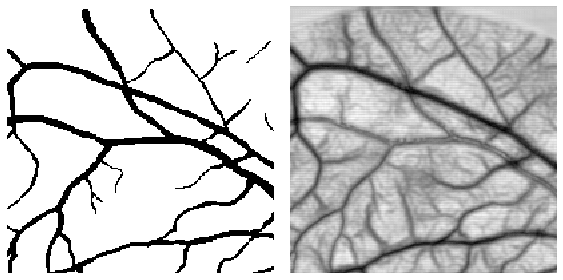

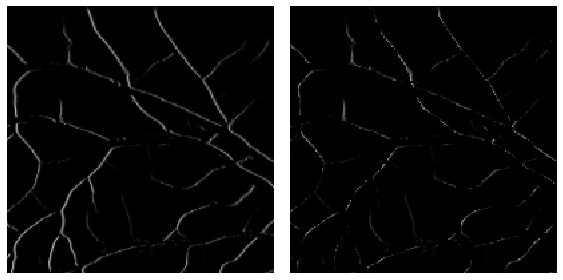

In [235]:
# xi,j - xi,j-1 (horizontal gradient, dark to bright: high pos values)
# using maked_probs_high, artificial jumps from dark to bright 
# are eliminated since all is bright now outside vessel
masked_tv_l = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-1)).detach() 
masked_tv_l[masked_tv_l>1]=0

imshow_pair(labels_oh[bb,ll,idd:idd+off1,idd2:idd2+off2],logits[bb,ll,idd:idd+off1,idd2:idd2+off2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)
imshow_pair(tv_l[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_tv_l[bb,ll,idd:idd+off1,idd2:idd2+off2])

In [236]:
masked_tv_l.min()

tensor(-2.9999)

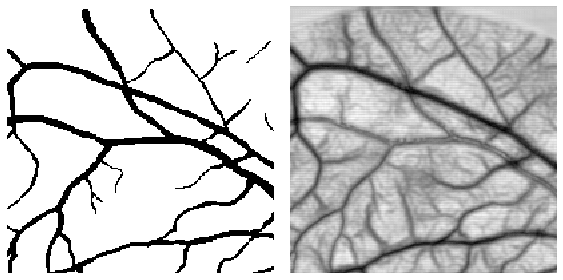

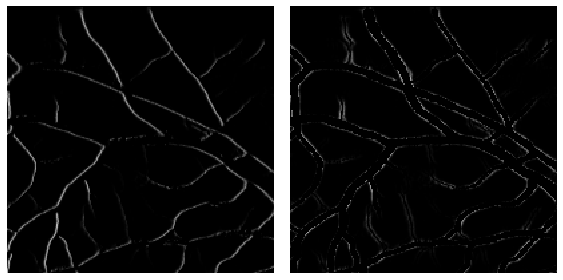

In [237]:
masked_tv_r = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-1)).detach()
masked_tv_r[masked_tv_r>1]=0

# combo: high pos value in bright to dark and dark to bright jumps only
masked_tv_lr = torch.clamp(torch.max(masked_tv_r, masked_tv_l), min=0,max=1)

imshow_pair(labels_oh[bb,ll,idd:idd+off1,idd2:idd2+off2],logits[bb,ll,idd:idd+off1,idd2:idd2+off2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)
imshow_pair(tv_r[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_tv_lr[bb,ll,idd:idd+off1,idd2:idd2+off2], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

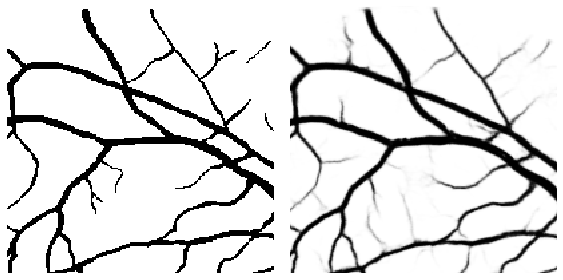

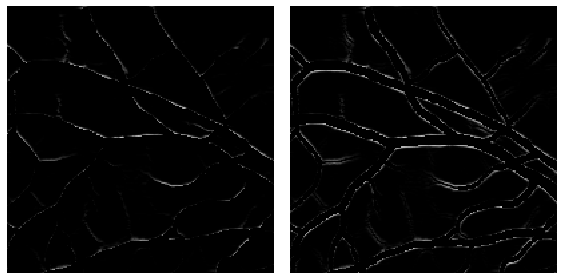

In [239]:
# xi,j - xi+1,j  (vertical gradient, bright to dark: high pos values)
masked_tv_u = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-2)).detach()
masked_tv_u[masked_tv_u>1]=0

# xi,j - xi-1,j (vertical gradient, dark to bright: high pos values)
masked_tv_d = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-2)).detach() 
masked_tv_d[masked_tv_d>1]=0

# combo: high pos value in bright to dark and dark to bright jumps only
masked_tv_ud = torch.clamp(torch.max(masked_tv_u, masked_tv_d), min=0,max=1)
imshow_pair(labels_oh[bb,0,idd:idd+off1,idd2:idd2+off2],probs[bb,0,idd:idd+off1,idd2:idd2+off2].detach())
imshow_pair(masked_tv_u[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_tv_ud[bb,ll,idd:idd+off1,idd2:idd2+off2], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [170]:
masked_tv_part_mean = torch.mean(torch.stack([masked_tv_ud, masked_tv_lr], axis=0), dim=0)
masked_tv_all_mean = torch.mean(torch.stack([masked_tv_u, masked_tv_d,masked_tv_l, masked_tv_r], axis=0), dim=0)

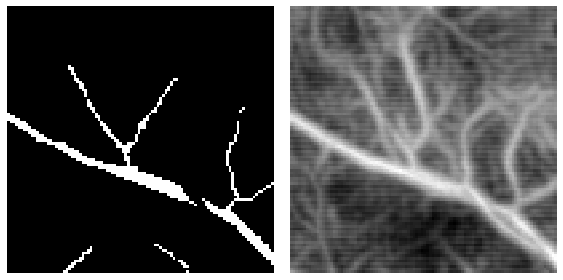

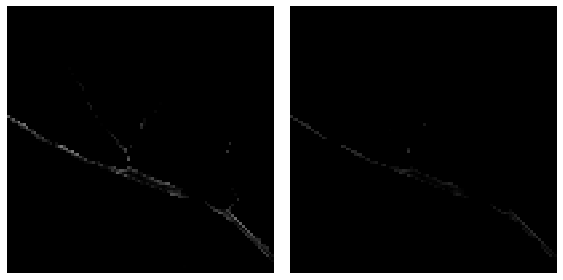

In [171]:
imshow_pair(labels_oh[bb,ll,idd:idd+off1,idd2:idd2+off2],logits[bb,ll,idd:idd+off1,idd2:idd2+off2].detach(),
           vmin1=None, vmin2=None, vmax1=None, vmax2=None)
imshow_pair(masked_tv_part_mean[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_tv_all_mean[bb,ll,idd:idd+off1,idd2:idd2+off2], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [175]:
masked_tv = torch.div(masked_tv_all_mean, torch.nn.Softmax(dim=1)(logits)+1e-4).detach()

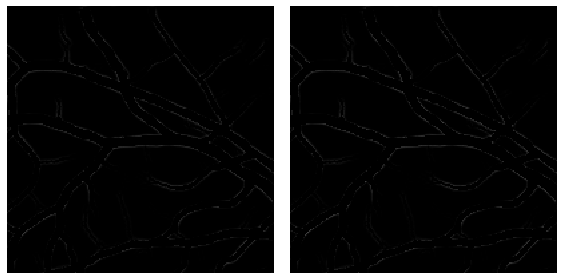

In [197]:
imshow_pair(masked_tv_all_mean[bb,ll,idd:idd+off1,idd2:idd2+off2], masked_tv[bb,ll,idd:idd+off1,idd2:idd2+off2], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

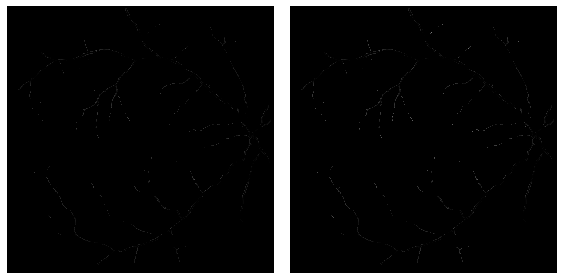

In [201]:
imshow_pair(masked_tv_all_mean[bb,3], masked_tv[bb,3], 
            vmin1=0, vmax1=1, vmin2=0, vmax2=1)

In [202]:
masked_tv_all_mean.max()

tensor(0.3019)

In [253]:
class MaskedTV(torch.nn.Module):
    def __init__(self, ignore_background=False, only_background=False, reduction='mean'):
        super(MaskedTV, self).__init__()
        self.reduction = reduction
        self.ignore_background = ignore_background
        self.only_background=only_background

    def compute_tv(self, logits, labels):

#         preds = torch.nn.Softmax(dim=1)(logits)
        labels_oh = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        masked_probs_high = torch.nn.Softmax(dim=1)(logits)
        masked_probs_high[~labels_oh]=3 # assign high values outside labels
        
        masked_tv_l = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-1))
        masked_tv_l = torch.clamp(masked_tv_l, min=0,max=1)
        
        masked_tv_r = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-1))
        masked_tv_r = torch.clamp(masked_tv_r, min=0,max=1)
        masked_tv_u = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=-1, dims=-2))
        masked_tv_u = torch.clamp(masked_tv_u, min=0,max=1)
        masked_tv_d = torch.sub(masked_probs_high, torch.roll(masked_probs_high, shifts=1, dims=-2)) 
        masked_tv_d = torch.clamp(masked_tv_d, min=0,max=1)
        masked_tv = torch.mean(torch.stack([masked_tv_u, masked_tv_d,masked_tv_l, masked_tv_r], axis=0), dim=0)
        
        return masked_tv

    def forward(self, logits, labels, **kwargs):
        # assumes logits is bs x n_classes H x W,
        #         labels is bs x H x W containing integer values in [0,...,n_classes-1]
        tv = self.compute_tv(logits, labels)
        
        ignore_map = torch.stack([labels == 0, labels == 1, labels == 2, labels == 3], dim=1)
        masked_tv = torch.mul(tv, ignore_map)
        masked_tv = torch.div(masked_tv, torch.nn.Softmax(dim=1)(logits)+1e-4)
        
        if self.ignore_background:
            masked_tv = masked_tv[:, 2:, ...]
            ignore_map = ignore_map[:, 2:, ...]
        if self.only_background:
            masked_tv = masked_tv[:, 0, ...]
            ignore_map = ignore_map[:,0, ...]
        if self.reduction == 'mean':  # 1 value for the entire batch
            mean_per_elem_per_class = (masked_tv.sum(dim=(-2, -1)) / ignore_map.sum(dim=(-2, -1)))
            return mean_per_elem_per_class.mean()
        elif self.reduction == 'none':  # n_classes values per element in batch
            return masked_tv
        else:
            sys.exit('not a valid reduction scheme')

In [254]:
perfect_logits = 100*torch.stack([(labels==0),(labels==1),(labels==2),(labels==3)],dim=1).float()
perfect_probs = torch.nn.Softmax(dim=1)(perfect_logits)

In [255]:
criterion  = MaskedTV(reduction='none',ignore_background=False)

In [256]:
tv_loss_perfect  = criterion(perfect_logits, labels)
tv_loss_perfect.mean().item(), tv_loss_perfect.max().item()

(0.0, 0.0)

In [257]:
tv_loss  = criterion(logits, labels)
tv_loss.mean().item(), tv_loss[0,0].max().item(), tv_loss[0,1].max().item(), \
tv_loss[0,2].max().item(), tv_loss[0,3].max().item()

(0.004010272677987814,
 0.47719061374664307,
 0.4969981014728546,
 0.4985731840133667,
 0.5002887845039368)

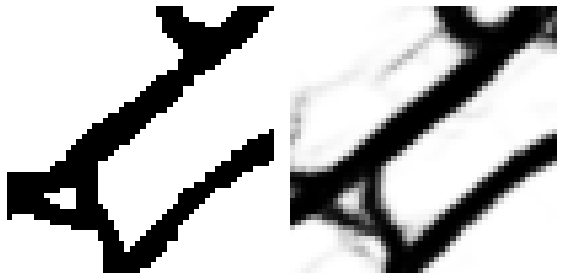

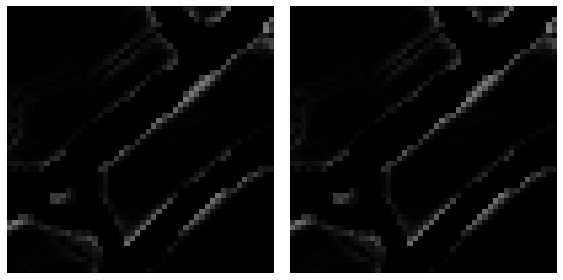

In [258]:
imshow_pair(perfect_probs[0,0,400:450,300:350].detach(), probs[0,0,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)
imshow_pair(tv_loss[0,0,400:450,300:350].detach(), tv_loss[0,0,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

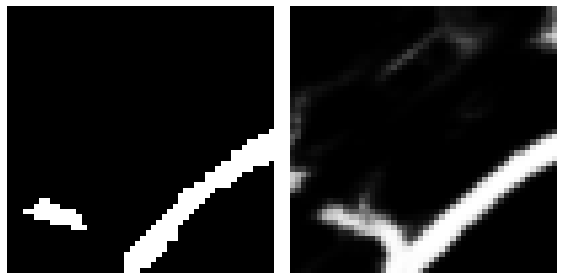

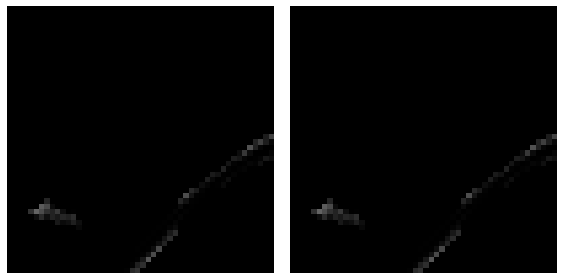

In [259]:
imshow_pair(perfect_probs[0,2,400:450,300:350].detach(), probs[0,2,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)
imshow_pair(tv_loss[0,2,400:450,300:350].detach(), tv_loss[0,2,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

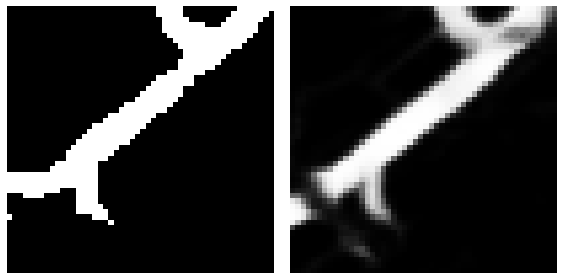

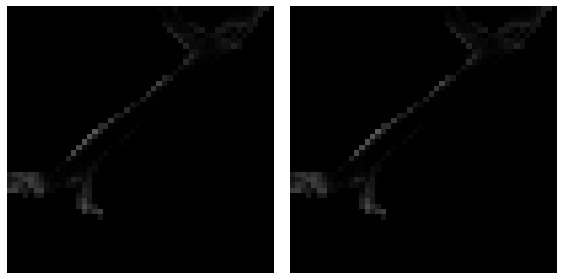

In [260]:
imshow_pair(perfect_probs[0,3,400:450,300:350].detach(), probs[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)
imshow_pair(tv_loss[0,3,400:450,300:350].detach(), tv_loss[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

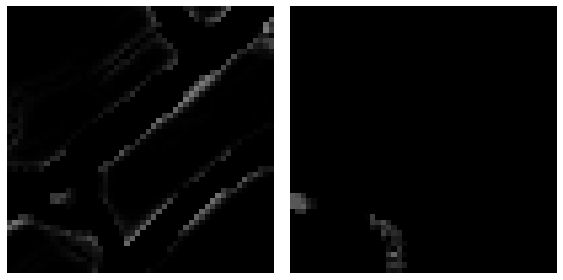

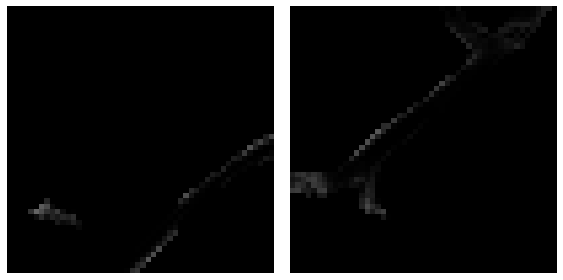

In [261]:
imshow_pair(tv_loss[0,0,400:450,300:350].detach(), tv_loss[0,1,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)
imshow_pair(tv_loss[0,2,400:450,300:350].detach(), tv_loss[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

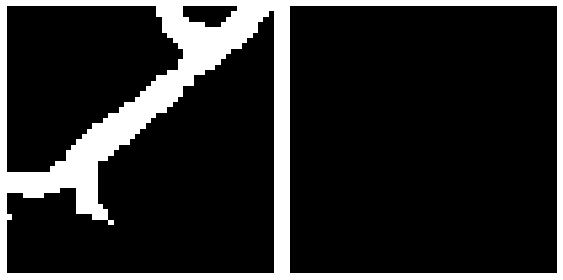

In [262]:
imshow_pair(perfect_probs[0,3,400:450,300:350], tv_loss_perfect[0,3,400:450,300:350].detach(), 
            vmin1=0,vmax1=1,vmin2=0,vmax2=1)

In [263]:
criterion  = MaskedTV(ignore_background=False)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

(0.06018028408288956, 0.0)

In [264]:
criterion  = MaskedTV(ignore_background=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

(0.06774576008319855, 0.0)

In [266]:
criterion  = MaskedTV(only_background=True)
criterion(logits, labels).item(), criterion(perfect_logits, labels).item()

(0.010326171293854713, 0.0)

In [92]:
# row 1: bright to dark, row 2: dark to bright
x = torch.tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 1]).view(2, 5)
x

tensor([[1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1]])

In [93]:
torch.roll(x, shifts=-1, dims=-1) # xi,j+1

tensor([[1, 1, 0, 0, 1],
        [0, 0, 1, 1, 0]])

In [94]:
# xi,j - xi,j+1 (horizontal gradient)
# bright to dark: high pos values on the bright pixel
# dark to bright: high neg values
x-torch.roll(x, shifts=-1, dims=-1)

tensor([[ 0,  0,  1,  0, -1],
        [ 0,  0, -1,  0,  1]])

In [95]:
torch.roll(x, shifts=1, dims=-1) # xi,j-1

tensor([[0, 1, 1, 1, 0],
        [1, 0, 0, 0, 1]])

In [96]:
# xi,j - xi,j-1 (horizontal gradient)
# bright to dark: high neg values
# dark to bright: high pos values on the bright pixel
x-torch.roll(x, shifts=1, dims=-1)

tensor([[ 1,  0,  0, -1,  0],
        [-1,  0,  0,  1,  0]])

In [97]:
# this gets us a high pos value on the bright pixel in bright to dark and dark to bright jumps only
torch.max(x-torch.roll(x, shifts=-1, dims=-1), x-torch.roll(x, shifts=1, dims=-1))

tensor([[1, 0, 1, 0, 0],
        [0, 0, 0, 1, 1]])